# Homework: Integration using Three Methods

[//]: # "未來：對一個 multi dimensional integration, 用 Gaussian quadrature 來做，然後與 QMC 比較。"



In [1]:
using HCubature, HaltonSequences, Statistics, FastGaussQuadrature, Plots, Interact, WebIO, StatsPlots, QuadGK, Distributions

WebIO._IJuliaInit()

##  Let's redo the integration problem using QMC:

  \begin{aligned}
   I = \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}
  
  - Use quasi Monte Carlo method to compute the following integration.
  - transform the infinite domain to $[0,1]$; mind the Jacobian;
  - draw Halton sequence from $[0,1]$;
  - compute the integration with a given $n$.
- Inspect the convergence path by computing $I$ using different values $n$, and draw a graph with $n$ and $I$ on the horizontal and vertical axes, respectively.

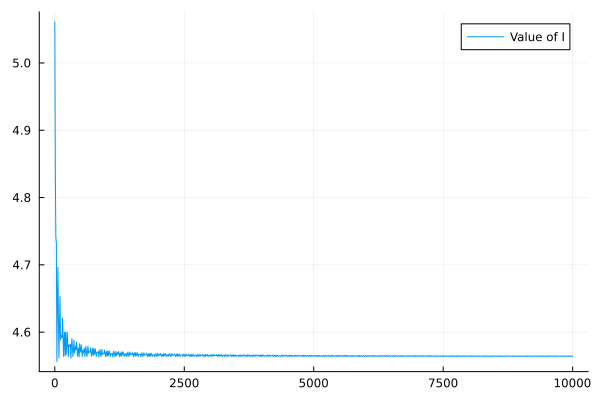

In [11]:
function VariIntg(m)
    x(t) = (2*t-1)/(t-t^2)
    g(x) = exp(-(x^2)/3)sqrt(1+x^2)
    f(t) = g(x(t))*(2*(t^2)-2*t+1)/(t^2-t)^2
    halton = Halton(3, length = m)
    answer = mean(f.(halton))
    return answer
end

answer = []
for n in 10:10:10000
    push!(answer,VariIntg(n))
end

plot(range(0,100,length = 1000).*100,answer,label = "Value of I")

## 
Consider the following integration problem:
\begin{align}
  I = \int_a^1 c\cdot x^{-k-1}(1-x)^{k+1}dx.
\end{align}
Assume $a = 10^{-5}$, $c=10^{-9}$, and $k=2$.

### Plot (multiple) graphs of the integrand to have a basic understanding of the problem. As you can see from the equation, the integrand may be tricky when $x$ approaches 0 and when $x$ approaches 1. Therefore, plot the graphs that highlight the integrand's shape near x=0 and x=1.

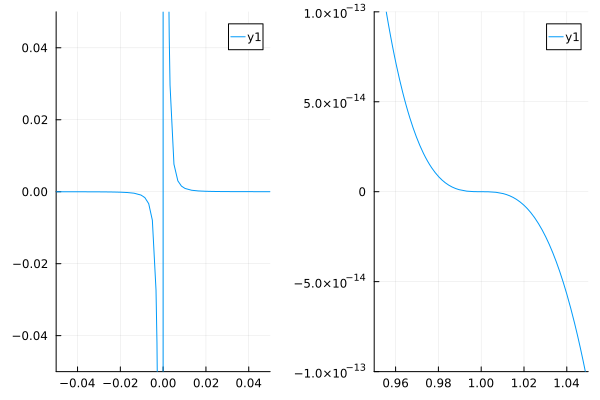

In [42]:
f(x) = 10^(-9)*(x^-3)*(1-x)^3
x0 = plot(f, xlim=(-0.05,0.05),ylim=(-0.05,0.05))
x1 = plot(f, xlim=(0.95,1.05),ylim=(-1e-13,1e-13))
plot(x0, x1)

### Use the Gauss-Legendre rule to compute the integral. How many nodes are required to have a stable solution (say, five digits after the decimal point are unchanged) ? 
- Hint: A lot of nodes.

In [3]:
function GLIntg(n)
    x(t) = (1e-5 + 1)/2 + t * (1 - 1e-5)/2
    g(x) = 10^(-9)*(x^-3)*(1-x)^3
    f(t) = g(x(t)) * (1 - 1e-5)/2
    xi, wi = gausslegendre(n)
    answer = sum( wi .* f.(xi))
    return answer
end

prev = 0
n = 100
while true
    n += 1
    if round(prev; digits = 5) == round(GLIntg(n); digits = 5)
        print("GL method needs n >= ",n," to converge.\n")
        break
    else
        prev = GLIntg(n)
    end
end
GLIntg(1148)

GL method needs n >= 1148 to converge.


4.998864752463534

### Use both of the Monte Carlo method (with pseudo random numbers) and Quasi-Monte Carlo method (with the Halton sequence) to compute the integral. How long does the sequences need to be in order to have a stable solution (2 digits after the decimal point)? Which method, MC or QMC, uses smaller values of $n$?
- Hint: A very long sequence.
- Hint: The following generates a Halton sequence of length 100 with the base number=2: `using HaltonSequences;` `lds=Halton(2,100)`.

MC method needs n >= 1004 to converge.
QMC method needs n >= 1001 to converge.


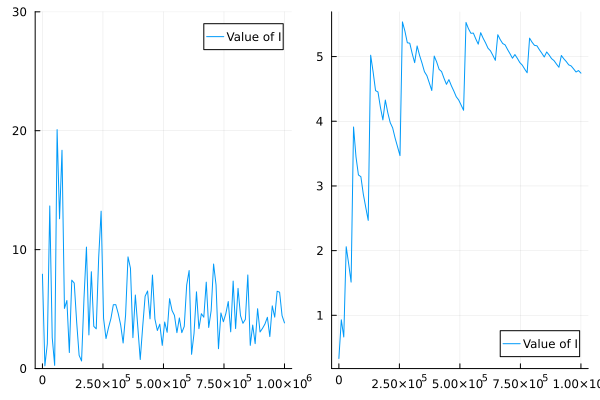

In [12]:
#MC
function MCIntg(n)
    x(t) = 1e-5 + (1- 1e-5) * t
    g(x) = 10^(-9)*(x^-3)*(1-x)^3
    f(t) = g(x(t))*(1- 1e-5)
    set = rand(Uniform(0, 1), n)
    answer = sum(f.(set))
    answer = answer / n
    return answer
end
prev = 0
n = 1000
while true
    n += 1
    if round(prev; digits = 2) == round(MCIntg(n); digits = 2) 
        print("MC method needs n >= ",n," to converge.\n")
        break
    else
        prev = MCIntg(n)
    end
end

#QMC
function QMCIntg(n)
    lds = Halton(2,length = n)
    x(t) = 1e-5 + (1- 1e-5) * t
    g(x) = 10^(-9)*(x^-3)*(1-x)^3
    f(t) = g(x(t))*(1- 1e-5)
    answer = mean(f.(lds))
    return answer
end
prev = 0
n = 1000
while true
    n += 1
    if round(prev; digits = 2) == round(QMCIntg(n); digits = 2) 
        print("QMC method needs n >= ",n," to converge.\n")
        break
    else
        prev = QMCIntg(n)
    end
end

MCanswer = []
for n in 10000:10000:1000000
    push!(MCanswer,MCIntg(n))
end

QMCanswer = []
for n in 10000:10000:1000000
    push!(QMCanswer,QMCIntg(n))
end

mcp = plot(range(0,1000,length = 100).*1000,MCanswer,label = "Value of I", ylim=(0,30))
qmcp = plot(range(0,1000,length = 100).*1000,QMCanswer,label = "Value of I")
plot(mcp, qmcp)
#  It seems that it's hard to check convergence by  n, so I use graph to check, QMC converge faster, 
#  and looks like MC is hard to converge at this case.

### Julia provides a package `QuadGK.jl` which has a function `quadgk()` that uses *adaptive quadratures* to do one-dimensional numerical integration. Use `using Pkg; Pkg.add("QuadGK.jl")` to install it, and `using QuadGK` to call it.
- Please read Section 1.3 on `Lec4 Numerical Integration - class.ipynb` to understand what is adaptive quadratures.
- Use `quadgk()` function to compute the integration.

In [16]:
quadgk(x -> 10^(-9)*(x^-3)*(1-x)^3, 1e-5, 1)

(4.999700036038788, 8.45481734276374e-10)

### You tried several methods to calculate the integration: The Gauss-Legendre method, the quasi-Monte Carlo method using the Halton sequence, the Monte Carlo method using random draws, and the adaptive quadrature method. How would you rank the methods from the most efficient (in terms of using a smaller number of draws/points, which usually translates to shorter run time) to the least efficient? Please explain the possible reasons behind the most and the least efficient methods.

1st: adaptive  
2nd: Gauss-Legendre  
3rd: QMC  
4th: MC  
Adaptive quadrature is the most efficient because it can deal with the region near 0 by divide domain into smaller one.  
MC is the least efficient in this case, because the shape of the function is weird near 0, and random point is hard to reach that region, so it may need a very large n to converge, which is very inefficient.    